## Import necessary modules, set up environment

In [39]:

from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
import gymnasium



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


## Set up the wrappers for the environment

`MissionEncodingWrapper` adds one for every discrete space in the one-hot encoding of the mission, allowing 0 to be encoded as well.

`ImageFeaturesExtractor` extracts relevant features if the observation is just an image, used with `ImgObsWrapper`

`MinigridFeaturesExtractor` extracts relevant features from the entire observation, used with `MissionEncodingWrapper` and `DictObservationSpaceWrapper`

In [40]:

from gymnasium import ObservationWrapper
import numpy as np
# a custom wrapper to make the mission vector work with one hot encoding
class MissionEncodingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['mission'] = spaces.MultiDiscrete(np.array([n+1 for n in env.observation_space['mission'].nvec]))
    def observation(self, obs):
        return obs

In [41]:
class ImageFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gymnasium.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [42]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
       
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

### Train the model and save it. -- also try `FlatObsWrapper`

In [45]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)

env.observation_space

Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MultiDiscrete([51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51
 51 51]))

In [38]:

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env) # so that the multidiscrete mission space is 51, accounting for values 0 through 50
env.metadata['render_modes'] = ["rgb_array"]


model = PPO("MultiInputPolicy", env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(2e5)

## the problem: ppo requires a gym env to train. but the env observation space is of type gymnasium.spaces. 

NameError: name 'MinigridFeaturesExtractor' is not defined

### Record Video of the trained policy

In [60]:
from utils import record_videos, show_videos

model = PPO.load("minigrid_models/minigrid-ppo/3-just-image-observation")

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env = ImgObsWrapper(env)
env = gymnasium.wrappers.RecordVideo(env, 'video', episode_trigger=lambda e: e % 2 == 0)

obs, info = env.reset()
done = False
env.start_video_recorder()
steps = 0
while not done and steps <= 10000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
    steps += 1
env.close_video_recorder()
env.close()
show_videos()

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/video/rl-video-episode-0.mp4


## How to render image

-- good for passing into GPT4 VLM

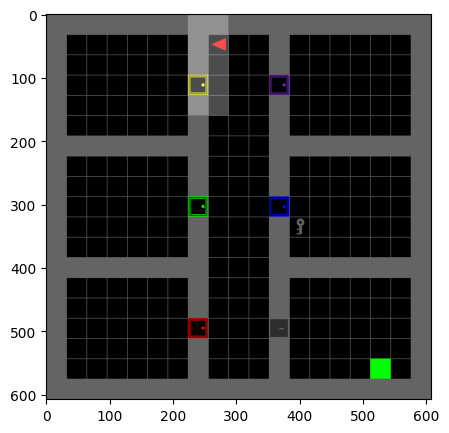

In [5]:
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

In [36]:
import os
from openai import OpenAI
import openai

def openai_repr(system_instructions, prompt):
    '''
    Query the OpenAI API to get the response to the prompt. Prompt something like
    '''

    # Set the OpenAI API key -- REPLACE THIS WITH YOUR OWN
    

    # Define the GPT model
    gpt_model = 'gpt-3.5-turbo'
    
    messages = [
        {"role": "system", "content": system_instructions},
        {"role": "user", "content": prompt}
    ]

    client = OpenAI() # pass api_key
   
    # Generate response using Chat Completion API
    response = client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2
    )

    return response

In [37]:
openai_repr("you are a robot", "what is the meaning of life")

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

## Custom Reward